# 0. Setup of Paths

In [175]:
import os

In [176]:
# File name, links that will be used frequently
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [177]:
# Paths that will be used frequently
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace', 'images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),  
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc'),
    'REALTIMEDETECTIONS_PATH': os.path.join('RealTimeDetections')
 }

In [178]:
# Files that will be used frequently
files = {
    'PIPELINE_CONFIG': os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
# Creating all needed directories
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Downloading TF Models Pretrained Models from Tensorflow Model Zoo and Installing TFOD

In [ ]:
# Tensorflow for Windows
# https://www.tensorflow.org/install/source_windows

In [ ]:
# Installing Wget for windows users
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
# Cloning into the Tensorflow repository to get TFOD
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Installing Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!pip list

In [ ]:
# Verification script from Tensorflow 
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verifying installation for TFOD
!python {VERIFICATION_SCRIPT}

In [ ]:
# Installing some other needed dependencies
!pip install tensorflow tensorflow-gpu --upgrade

In [ ]:
!pip install scipy

In [ ]:
!pip install tf-models-official

In [ ]:
!pip install tensorflow.io

In [ ]:
!pip list

In [ ]:
# Reverifying installation
!python {VERIFICATION_SCRIPT}

In [ ]:
# Downloading and unzipping pretrained model
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Creating the Label Map

In [179]:
# Creating the Label Map
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Creating TF records

In [ ]:
# Downloading dataset from
# https://www.kaggle.com/datasets/andrewmvd/car-plate-detection?resource=download

In [ ]:
# If running on colab, run this instruction
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
# Cloning script to generate TF records
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!pip install pytz

In [ ]:
# Creating TF records
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copying Model Config to Training Folder

In [ ]:
# Copying model config file to training folder
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Updating Config For Transfer Learning

In [180]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [181]:
# Getting configs from pipeline config file
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [182]:
# Read contents of pipeline config file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()  
    text_format.Merge(proto_str, pipeline_config)  

In [183]:
# Update config file for transfer learning
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
# Write updated configs to pipeline config file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Training the model

In [ ]:
# Training script from TFOD
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
# Generating training command
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
# Installing needed dependency for training
!pip install lvis

In [ ]:
# Running training process
!{command}

# 7. Evaluating the Model

In [ ]:
# Generating model evaluation command
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
# Running evaluating process
!{command}

# 8. Loading Trained Model From Checkpoint and Building a Detection Model

In [ ]:
# Installing dependency for GPU consumption
!pip install GPUtil

In [184]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import GPUtil

In [185]:
# Preventing GPU from complete consumption of resources
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [186]:
# Loading pipeline config file
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restoring latest checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()


# Building a detection model
@tf.function
def detect_fn(image):
    """Build detection model function

        Parameters:
            image (tensorflow.python.framework.ops.EagerTensor): tensorflow image to detect plate on

        Returns:
            detections (dict, dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 
            'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])): 
            detected plate"""
    
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detecting plate from an Image, OCR, Saving Results

# 9. a) Detecting plate from an Image

In [ ]:
# Installing needed dependencies detection
!pip install avro-python3

In [ ]:
!pip install opencv-python

In [187]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [188]:
# Categories extracted from labelmap
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [189]:
# Image to detect plate number from
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'Cars1.png')

ORIGINAL


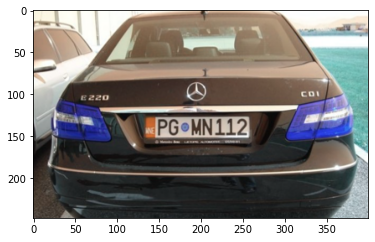

IMPROVED RESOLUTION


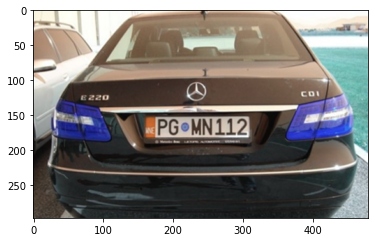

DETAILS ENHANCED


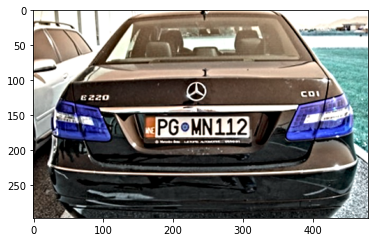

BILATERAL FILTER ENHANCED


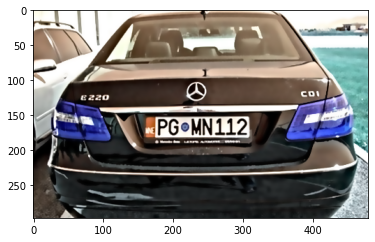

BILATERAL GRAY ENHANCED


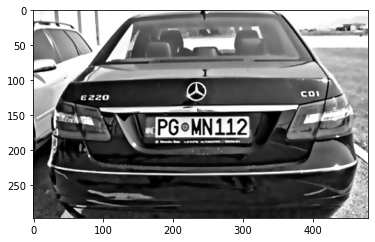

THRESH 1 ENHANCED


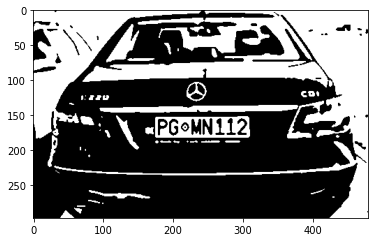

Detected plate


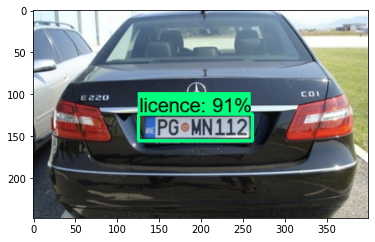

In [190]:
# Preprocessing image
img_orig = cv2.imread(IMAGE_PATH)
print('ORIGINAL')
plt.imshow(img_orig)
plt.show()

img_resized = cv2.resize(img_orig, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
print('IMPROVED RESOLUTION')
plt.imshow(img_resized)
plt.show()

img_detailsEnhanced = cv2.detailEnhance(img_resized, sigma_s=10, sigma_r=0.15)
print('DETAILS ENHANCED')
plt.imshow(img_detailsEnhanced)
plt.show()

img_BilateralFilterEnhanced = cv2.bilateralFilter(img_detailsEnhanced, 9, 75, 75)
print('BILATERAL FILTER ENHANCED')
plt.imshow(img_BilateralFilterEnhanced)
plt.show()

img_BilateralFilterEnhancedGray = cv2.cvtColor(img_BilateralFilterEnhanced, cv2.COLOR_BGR2GRAY)
print('BILATERAL GRAY ENHANCED')
plt.imshow(img_BilateralFilterEnhancedGray, cmap='gray')
plt.show()

img_threshEnhanced = cv2.threshold(cv2.medianBlur(img_BilateralFilterEnhancedGray, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
print('THRESH 1 ENHANCED')
plt.imshow(img_threshEnhanced, cmap='gray')
plt.show()

img_backtorgb = cv2.cvtColor(img_threshEnhanced,cv2.COLOR_GRAY2RGB)

image_np = np.array(img_orig)

# Detection
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# Detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Visualizing detection
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

print('Detected plate')
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 9. b) OCR Filtering

In [ ]:
# Installing EasyOCR and needed dependencies
!pip install easyocr

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [191]:
import easyocr

In [192]:
# Filter OCR function
def filter_text(region, ocr_result, region_threshold) -> list:
    """Filter OCR function

        Parameters:
            region (numpy.ndarray): region of interest for plate detection 
            ocr_result (list): OCR characters
            region_threshold (float): threshold for region to run OCR over

        Returns:
            plate (list): plate characters"""
    
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

# 9. c) OCR proccess and filtering

In [193]:
# Thresholds for detection and OCR filtering
detection_threshold = 0.7
region_threshold = 0.6

In [194]:
# OCR function
def ocr_it(image, detections, detection_threshold, region_threshold):
    """OCR function

        Parameters:
            image (tensorflow.python.framework.ops.EagerTensor): tensorflow image to detect plate on
            detections (dict, dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 
            'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])): 
            detected plate: 
            detection_threshold (float): threshold for detection to be considerred successfull
            region_threshold (float): threshold for region to run OCR over

        Returns:
            text (list): plate characters 
            region (tensorflow.python.framework.ops.EagerTensor): tensorflow image, detected plate region """
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

# 9. d) Saving Results

In [195]:
import csv
import uuid
from datetime import datetime

In [196]:
# Saving detections
def save_results(text, region):
    """Save results function

        Parameters:
            text (list): plate characters 
            region (tensorflow.python.framework.ops.EagerTensor): tensorflow image, detected plate region

        Returns: N/A"""
    
    now = datetime.now()
    date_string = now.strftime('%y-%m-%d')
    print(date_string)
    time_string = now.strftime('%H-%M-%S')
    print(time_string)
    
    folder_path_images = 'RealTimeDetectionsImages\RealTimeDetections-{}'.format(date_string)
    img_name = '{}_{}.jpg'.format(time_string, uuid.uuid1())
    forlder_path_csv = 'RealTimeDetections'
    csv_filename = 'RealTimeDetections\RealTimeDetections-{}.csv'.format(date_string)
    
    if not os.path.exists(folder_path_images):
        if os.name == 'posix':
            !mkdir -p {folder_path_images}
        if os.name == 'nt':
            !mkdir {folder_path_images}
    
    if not os.path.exists(forlder_path_csv):
        if os.name == 'posix':
            !mkdir -p {forlder_path_csv}
        if os.name == 'nt':
            !mkdir {forlder_path_csv}
            
    cv2.imwrite(os.path.join(folder_path_images, img_name), region)
                
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        if text == []:
            text = ['unreadable']
        csv_writer.writerow([date_string, time_string, img_name, text])
        

# 10. Real Time Detections from Webcam

In [197]:
import cv2

<class 'tensorflow.python.framework.ops.Tensor'>


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


<class 'numpy.ndarray'>
<class 'list'>
<class 'float'>
<class 'list'>


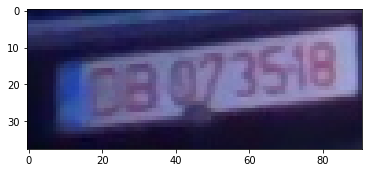

[]
22-06-20
19-36-13


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


<class 'numpy.ndarray'>
<class 'list'>
<class 'float'>
<class 'list'>


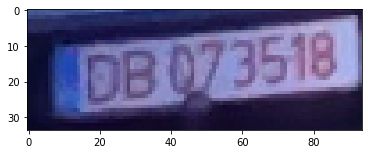

['DE0B5E']
22-06-20
19-36-15


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


<class 'numpy.ndarray'>
<class 'list'>
<class 'float'>
<class 'list'>


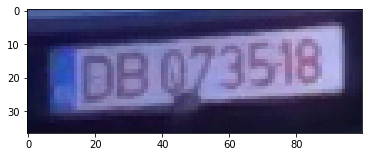

['DB70518']
22-06-20
19-36-17


In [172]:
# Real Time Detections from Webcam
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()

    # Preprocessing image
    img_resized = cv2.resize(frame, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
    img_detailsEnhanced = cv2.detailEnhance(img_resized, sigma_s=10, sigma_r=0.15)
    img_BilateralFilterEnhanced = cv2.bilateralFilter(img_detailsEnhanced, 9, 75, 75)
    img_BilateralFilterEnhancedGray = cv2.cvtColor(img_BilateralFilterEnhanced, cv2.COLOR_BGR2GRAY)
    img_threshEnhanced = cv2.threshold(cv2.medianBlur(img_BilateralFilterEnhancedGray, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img_backtorgb = cv2.cvtColor(img_threshEnhanced,cv2.COLOR_GRAY2RGB)
    
    image_np = np.array(frame)
    image_np_preprocessed = np.array(img_backtorgb)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np_preprocessed, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    # Detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region)
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 11. Getting and processing data from the CSV detection files

# 11. a) Getting data from CSV file

In [198]:
import os
import csv
from os import listdir
from os.path import isfile, join
import pandas as pd
from datetime import datetime

In [199]:
def getDataFromCsv(elem):
    """Get data from CSV function

        Parameters:
            elem (*.csv file): CSV file

        Returns: 
        [listDateNew, listTimeNew, listFileNameNew, listPlateNew] (list): lists of detection dates, timestamps, filenames, plates"""
    
    
    dataDate = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[0])
    dataTime = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[1])
    dataFileName = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[2])
    dataPlate = pd.read_csv(os.path.join('RealTimeDetections', elem), header=None, usecols=[3])
    
    listDate = dataDate.values.tolist()
    listTime = dataTime.values.tolist()
    listFileName = dataFileName.values.tolist()
    listPlate = dataPlate.values.tolist()
    
    listDateNew = [elem[0] for elem in listDate]
    listTimeNew = [elem[0] for elem in listTime]
    listFileNameNew = [elem[0] for elem in listFileName]
    listPlateNew = [elem[0] for elem in listPlate]
    
    listPlateNewNew = []
    for elem in listPlateNew:
        elem = elem[2:-2]
        listPlateNewNew.append(elem)
     
    # print(listDateNew)
    # print()
    # print(listTimeNew)
    # print()
    # print(listFileNameNew)
    # print()
    # print(listPlateNewNew)
    # print()
    # print("--------------------------------------------------------")
    
    return [listDateNew, listTimeNew, listFileNameNew, listPlateNew]

# 11. b) Redundancy plate process

In [200]:
def redundancyFunction(datesToPass, timestampsToPass, filenamesToPass, platesToPass):    
    """Build detection model function
        Parameters:
            datesToPass (list): detection dates
            timestampsToPass (list): detection timestamps
            filenamesToPass (list): detection filenames
            platesToPass (list): detection plates
        Returns:
            [timestampsValids, datesValids, filenamesValids, platesValids] (list): lists of detection dates, timestamps, filenames, plates"""
    
    datesValids = []
    timestampsValids = []
    filenamesValids = []
    platesValids = []
    
    for i, timestampi in enumerate(timestampsToPass):
        datesValid = []
        timestampsValid = []
        filenamesValid = []
        platesValid = []
        onlyOne = True
        
        timestamp1 = (datetime.strptime(timestampi,"%H-%M-%S").time())
        
        flag = True
        if(len(timestampsValids) != 0):
            for elem in timestampsValids:
                if timestamp1.strftime("%H-%M-%S") in elem:
                    flag = False
                    break
        
        if(timestampi != timestampsToPass[-1] and flag == True):
            for j, timestampj in enumerate(timestampsToPass[i+1:]):
                timestamp2 = (datetime.strptime(timestampj,"%H-%M-%S").time())
                # print(f'{timestamp1}, {timestamp2}')
                if((timestamp1.hour == timestamp2.hour) and (timestamp1.minute == timestamp2.minute)):
                    if(timestamp1.strftime("%H-%M-%S") not in timestampsValid):
                        timestampsValid.append(timestamp1.strftime("%H-%M-%S"))
                        datesValid.append(datesToPass[i])
                        filenamesValid.append(filenamesToPass[i])
                        platesValid.append(platesToPass[i])
                    if timestamp2 not in timestampsValid:
                        timestampsValid.append(timestamp2.strftime("%H-%M-%S"))
                        datesValid.append(datesToPass[i+1+j])
                        filenamesValid.append(filenamesToPass[i+1+j])
                        platesValid.append(platesToPass[i+1+j])
                        onlyOne = False
                elif(onlyOne == True):
                    timestampsValid.append(timestamp1.strftime("%H-%M-%S"))
                    datesValid.append(datesToPass[i])
                    filenamesValid.append(filenamesToPass[i])
                    platesValid.append(platesToPass[i])
                    break
                else:
                    break
        
        if(len(timestampsValid) != 0):
            timestampsValids.append(timestampsValid)
            datesValids.append(datesValid)
            filenamesValids.append(filenamesValid)
            platesValids.append(platesValid)
    
    # print(timestampsValids)
    # print()
    # print(datesValids)
    # print()
    # print(filenamesValids)
    # print()
    # print(platesValids)
    # print()
    
    return [timestampsValids, datesValids, filenamesValids, platesValids]

# 11. c) Redundancy plate text process

In [210]:
def processPlate(stringsUnreadable, dates, timestamps, filenames):
    """Redundancy function

        Parameters:
            stringsUnreadable (list): detected plates
            dates (list): detected dates
            timestamps (list): detected timestamps
            filenames (list): detected filenames

        Returns: 
        stringFinal (str): processed plate"""
    
    
    # print(f'Placute neprocesate:\n{stringsUnreadable}\n')
    
    breakFlag = False
    
    strings = []
    for index, elem in enumerate(stringsUnreadable):
        if elem != "['unreadable']":
            strings.append(elem)
    
    counts_unreadable = []
    for elem in stringsUnreadable:
        counts_unreadable.append(stringsUnreadable.count(elem))
    # print(counts_unreadable)
    
    maximum_unreadable = max(counts_unreadable)
    if(maximum_unreadable != "['unreadable']"):
        maximum_index_unreadable = counts_unreadable.index(maximum_unreadable)
        dateKept = dates[maximum_index_unreadable]
        timestampKept = timestamps[maximum_index_unreadable]
        filenameKept = filenames[maximum_index_unreadable]
    else:
        maximum_index_unreadable = random.randrange(0, len(counts_unreadable))
        dateKept = dates[maximum_index_unreadable]
        timestampKept = timestamps[maximum_index_unreadable]
        filenameKept = filenames[maximum_index_unreadable]
    
    # print(f'Numar de placute: {len(strings)}\n')
    # print(f'Placute:\n{strings}\n')

    strings_sorted = strings
    strings_sorted.sort()
    # print(f'Placute sortate:\n{strings_sorted}\n')

    strings_unique = set(strings)
    strings_unique = list(strings_unique)
    # print(f'Placute fara dubluri:\n{strings_unique}\n')

    if len(strings_unique) == 0:
        breakFlag = True
    
    if breakFlag == True:
        stringFinal = stringsUnreadable[0]
        dateKept = dates[0]
        timestampKept = timestamps[0]
        filenameKept = filenames[0]
    
    if breakFlag == False:
        counts = []
        for elem in strings_unique:
            counts.append(strings.count(elem))
        # print(f'Numar de aparitii fiecare placuta unica:\n{counts}\n')

        maximum = max(counts)
        maximum_index = counts.index(maximum)
        # print(f'Cel mai mare numar de aparitii: {maximum}')
        # print(f'Se afla la indexul: {maximum_index}\n')

        stringsValues = []
        stringsCounts = []
        if(counts.count(maximum) == 1):
            for index, elem in enumerate(strings_unique):
                if (len(elem) == len(strings_unique[maximum_index])):
                    stringsValues.append(elem)
                    stringsCounts.append(counts[index])
                else:
                    pass
                    # print(f'{elem} stearsa din detectii!')
        elif(counts.count(maximum) == len(strings_unique)):
            for index, elem in enumerate(strings_unique):
                if (len(elem) == len(strings_unique[0])):
                    stringsValues.append(elem)
                    stringsCounts.append(counts[index])
        else:
            for index, elem in enumerate(strings_unique):
                if (len(elem) == len(strings_unique[maximum_index])):
                    stringsValues.append(elem)
                    stringsCounts.append(counts[index])

        # print(f'\nPlacute luate in considerare:\n{stringsValues}')
        # print(f'Cu numerele de apartii:\n{stringsCounts}\n')

        literePosibilePlacuta = []
        factoriPlacuta = []
        for i in range(0, len(strings_unique[maximum_index])):
            literePosibile = []
            factori = []
            for index, elem in enumerate(stringsValues):
                # print(f'Litera de pe indexul {i} din placuta cu numarul {index} este {elem[i]} si are un factor de {stringsCounts[index]}')
                literaPosibila = elem[i]
                factor = counts[index]
                if literaPosibila not in literePosibile:
                    literePosibile.append(literaPosibila)
                    factori.append(factor)
                else:
                    indexLiteraExistenta = literePosibile.index(literaPosibila)
                    factori[indexLiteraExistenta] += factor
            # print()
            literePosibilePlacuta.append(literePosibile)
            factoriPlacuta.append(factori)

        for i in range(0, len(strings_unique[maximum_index])):
            pass
            # print(f'Pentru caracterul de pe indexul {i} luam in considerare: {literePosibilePlacuta[i]} cu factorii {factoriPlacuta[i]}')
        # print()

        stringFinal = ''
        for index, elem in enumerate(literePosibilePlacuta):
            if(len(elem) == 1):
                # print(f'Pentru indexul {index} am ales {elem[0]}')
                stringFinal = stringFinal + elem[0]
            else:
                maximum_local = max(factoriPlacuta[index])
                maximum_local_index = factoriPlacuta[index].index(maximum_local)
                # print(f'Pentru indexul {index} am ales {elem[maximum_local_index]}')
                stringFinal = stringFinal + elem[maximum_local_index]

    print(f'\nPlacuta finala: {stringFinal}')
    # print(f'\nPreluata la data de: {dateKept}')
    # print(f'\nOra: {timestampKept}')
    # print(f'\nFisierul: {filenameKept}')
    # print('================================')
    return [stringFinal, dateKept, timestampKept, filenameKept]

# 11. d) Compute final plates

In [202]:
csvfiles = [f for f in listdir('RealTimeDetections') if isfile(join('RealTimeDetections', f)) and f.endswith('.csv')]
# First one doesn't conform to the template
# csvfiles = csvfiles[2:]
# print(csvfiles)


for elem in csvfiles:
    csvReturns = []
    redReturns = []
    finalPlate = ''
    
    [csvListDateReturn, csvListTimeReturn, csvListFileNameReturn, csvListPlateReturn] = getDataFromCsv(elem)
    csvReturns.extend([csvListDateReturn, csvListTimeReturn, csvListFileNameReturn, csvListPlateReturn])
    
    # print(csvReturns[0])
    # print()
    # print(csvReturns[1])
    # print()
    # print(csvReturns[2])
    # print()
    # print(csvReturns[3])
    # print('---------------------------------------')
    
    [redListDateReturn, redListTimeReturn, redListFileNameReturn, redListPlateReturn] = redundancyFunction(csvReturns[0], csvReturns[1], csvReturns[2], csvReturns[3])
    redReturns.extend([redListDateReturn, redListTimeReturn, redListFileNameReturn, redListPlateReturn])
    
    # print(redReturns[0])
    # print()
    # print(redReturns[1])
    # print()
    # print(redReturns[2])
    # print()
    # print(redReturns[3])
    # print('---------------------------------------')
    

    
    for i, platesToProc in enumerate (redReturns[3]):
        finalPlate = processPlate(platesToProc, redReturns[1][i], redReturns[0][i], redReturns[2][i])
        
        f = open(join('RealTimeDetections\\Processed', f'Processed_{finalPlate[1]}.csv'), 'a')

        # create the csv writer
        writer = csv.writer(f)
        
        finalPlate0 = finalPlate[0].replace(' ', '')
        finalPlate0 = finalPlate0.upper()
        
        row = [finalPlate[1], finalPlate[2], finalPlate[3], finalPlate0]
        # write a row to the csv file
        writer.writerow(row)

        # close the file
        f.close()

# 11. e) Postprocess CSV files containing detection info

In [ ]:
csvProcessedfiles = [f for f in listdir('RealTimeDetections\\Processed') if isfile(join('RealTimeDetections\\Processed', f)) and f.endswith('.csv')]

for elem in csvProcessedfiles:
    findIndex = elem.find('.csv')
    elemOutput = elem[:findIndex]
    elemOutput = elemOutput + "_NoBlanks.csv"
    
    with open(join('RealTimeDetections\\Processed', elem), 'r') as inputFile, open(join('RealTimeDetections\\NoBlanks', elemOutput), 'w', newline='') as outputFile:
        writer = csv.writer(outputFile)
        for row in csv.reader(inputFile):
            if any(field.strip() for field in row):
                writer.writerow(row)

# 12. Send email alerts

In [203]:
# Import smtplib and ssl for the actual sending function
import smtplib, ssl

# Import the email modules we'll need
from email.message import EmailMessage

# To send also the date and the time
from datetime import datetime

In [204]:
smtp_server = "smtp.mail.yahoo.com"
port = 587  # For starttls
sender = 'anprthesis@yahoo.com'
receiver = 'anprthesis@gmail.com'
password = 'wamxfatshsvkanyb'

# Create a secure SSL context
context = ssl.create_default_context()


def sendAlert(followerType, followerPlate):
    """Send mail alerts function.

    Parameters:
        followerType (str): follower type
        followerPlate (str): follower plate

    Returns: N/A"""

    # Try to log in to server and send email
    try:
        server = smtplib.SMTP(smtp_server,port)
        server.ehlo()
        server.starttls(context=context) # Secure the connection
        server.ehlo()
        server.login(sender, password)
        
        emailMsg = EmailMessage()
        
        nowMoment = datetime.now()
        date_string = nowMoment.strftime('%y-%m-%d')
        time_string = nowMoment.strftime('%H-%M-%S')

        msg = f'You are being followed by {followerPlate}, date {date_string}, time {time_string}.\nType of follower: {followerType}.'
    
        emailMsg.set_content(msg)
        
        emailMsg['Subject'] = f'Dangerous car behind!'
        emailMsg['From'] = sender
        emailMsg['To'] = receiver

        server.send_message(emailMsg)
        
    except Exception as e:
        print(e)
        
    finally:
        server.quit()

# 13. Threading, Real Time Detections, Processing of Detections, Alert

In [211]:
from time import sleep, perf_counter
from threading import Thread
import shutil

# File cleanup
src = 'RealTimeDetections\\NoBlanks'
trg = 'RealTimeDetections\\ForDetections'
deleteProcessed = 'RealTimeDetections\\Processed'
deleteNoBlanks = 'RealTimeDetections\\NoBlanks'
    
sourceFiles = os.listdir(src)
targetFiles = os.listdir(trg)
deleteProcessedFiles = os.listdir(deleteProcessed)
deleteNoBlanksFiles = os.listdir(deleteNoBlanks)

for fname in targetFiles:
    if (isfile(join(trg, fname)) and fname.endswith('.csv')):
        os.remove(os.path.join(trg, fname))
        
# Copying files used for alerts to their correct directory
for fname in sourceFiles:
    shutil.copy2(os.path.join(src, fname), trg)
    

for fname in deleteNoBlanksFiles:
    if (isfile(join(deleteNoBlanks, fname)) and fname.endswith('.csv')):
        os.remove(os.path.join(deleteNoBlanks, fname))
for fname in deleteProcessedFiles:
    if (isfile(join(deleteProcessed, fname)) and fname.endswith('.csv')):
        os.remove(os.path.join(deleteProcessed, fname)) 

        
def task1():
    """
    Task 1 for parallel processing. Real Time detections and alerts.
    """
    
    # Computing a list of previous detections
    csvForDetectionsfiles = [f for f in listdir('RealTimeDetections\\ForDetections') if isfile(join('RealTimeDetections\\ForDetections', f)) and f.endswith('.csv')]
    
    previousDetections = []
    for elemCsvForDetections in csvForDetectionsfiles:
    
        detections = pd.read_csv(os.path.join('RealTimeDetections\\ForDetections', elemCsvForDetections), header=None, usecols=[3])
        listDetections = detections.values.tolist()
        listDetectionsNew = [elem[0] for elem in listDetections]
        listDetectionsNewNew = [elem[2:-2] for elem in listDetectionsNew]
        for elem in listDetectionsNewNew:
            previousDetections.append(elem)
    
    # Real Time Detections from Webcam
    cap = cv2.VideoCapture(0)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    nowDetections = []
    while cap.isOpened(): 
        ret, frame = cap.read()

        # Preprocessing image
        img_resized = cv2.resize(frame, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
        img_detailsEnhanced = cv2.detailEnhance(img_resized, sigma_s=10, sigma_r=0.15)
        img_BilateralFilterEnhanced = cv2.bilateralFilter(img_detailsEnhanced, 9, 75, 75)
        img_BilateralFilterEnhancedGray = cv2.cvtColor(img_BilateralFilterEnhanced, cv2.COLOR_BGR2GRAY)
        img_threshEnhanced = cv2.threshold(cv2.medianBlur(img_BilateralFilterEnhancedGray, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        img_backtorgb = cv2.cvtColor(img_threshEnhanced,cv2.COLOR_GRAY2RGB)
    
        image_np = np.array(frame)
        image_np_preprocessed = np.array(img_backtorgb)
    
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np_preprocessed, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
    
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
        detections['num_detections'] = num_detections
    
        # Detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(image_np_with_detections,detections['detection_boxes'],detections['detection_classes']+label_id_offset,detections['detection_scores'],category_index,use_normalized_coordinates=True,max_boxes_to_draw=5,min_score_thresh=.8,agnostic_mode=False)
    
        try:
            text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
            save_results(text, region)
            
            toCheck = text[0]
            toCheck = toCheck.replace(' ', '')
            toCheck = toCheck.upper()
            
            # Sending alerts
            if ((toCheck in previousDetections) or (nowDetections.count(toCheck) > 1)):
                nowDetections.append(toCheck)
                if ((toCheck in previousDetections) and (nowDetections.count(toCheck) > 1)):
                    typeOfFollowing = 'detected previously and following you now'
                    print(f'Danger, {typeOfFollowing}.')
                    sendAlert(typeOfFollowing, toCheck)
                elif (toCheck in previousDetections):
                    typeOfFollowing = 'detected in a previous moment'
                    print(f'Danger, {typeOfFollowing}.')
                    sendAlert(typeOfFollowing, toCheck)
                else:
                    typeOfFollowinf = 'detected for too long in this moment'
                    print(f'Danger, {typeOfFollowing}.')
                    sendAlert(typeOfFollowing, toCheck)
            else:
                print('Safe')
            
        except:
            pass
            
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

            
def task2():
    """
    Task 2 for parallel processing. Cleanup of files, processing past detections.
    """
    
    csvfiles = [f for f in listdir('RealTimeDetections') if isfile(join('RealTimeDetections', f)) and f.endswith('.csv')]
    # First one doesn't conform to the template
    # csvfiles = csvfiles[2:]
    # print(csvfiles)


    for elem in csvfiles:
        csvReturns = []
        redReturns = []
        finalPlate = ''
    
        [csvListDateReturn, csvListTimeReturn, csvListFileNameReturn, csvListPlateReturn] = getDataFromCsv(elem)
        csvReturns.extend([csvListDateReturn, csvListTimeReturn, csvListFileNameReturn, csvListPlateReturn])
            
        #print(csvReturns[0])
        #print()
        #print(csvReturns[1])
        #print()
        #print(csvReturns[2])
        #print()
        #print(csvReturns[3])
        #print('---------------------------------------')
    
        [redListDateReturn, redListTimeReturn, redListFileNameReturn, redListPlateReturn] = redundancyFunction(csvReturns[0], csvReturns[1], csvReturns[2], csvReturns[3])
        redReturns.extend([redListDateReturn, redListTimeReturn, redListFileNameReturn, redListPlateReturn])
    
        #print(redReturns[0])
        #print()
        #print(redReturns[1])
        #print()
        #print(redReturns[2])
        #print()
        #print(redReturns[3])
        #print('---------------------------------------')
    
        for i, platesToProc in enumerate (redReturns[3]):
            finalPlate = processPlate(platesToProc, redReturns[1][i], redReturns[0][i], redReturns[2][i])
        
            f = open(join('RealTimeDetections\\Processed', f'Processed_{finalPlate[1]}.csv'), 'a')

            # create the csv writer
            writer = csv.writer(f)
        
            row = [finalPlate[1], finalPlate[2], finalPlate[3], finalPlate[0]]
            # write a row to the csv file
            writer.writerow(row)

            # close the file
            f.close()
        
        csvProcessedfiles = [f for f in listdir('RealTimeDetections\\Processed') if isfile(join('RealTimeDetections\\Processed', f)) and f.endswith('.csv')]

        for elem in csvProcessedfiles:
            findIndex = elem.find('.csv')
            elemOutput = elem[:findIndex]
            elemOutput = elemOutput + "_NoBlanks.csv"
    
        with open(join('RealTimeDetections\\Processed', elem), 'r') as inputFile, open(join('RealTimeDetections\\NoBlanks', elemOutput), 'w', newline='') as outputFile:
            writer = csv.writer(outputFile)
            for row in csv.reader(inputFile):
                if any(field.strip() for field in row):
                    writer.writerow(row)    

    
start_time = perf_counter()

# Create two new threads
t1 = Thread(target=task1)
t2 = Thread(target=task2)

# Start the threads
t1.start()
t2.start()

# Wait for the threads to complete
t1.join()
t2.join()

end_time = perf_counter()

print(f'It took {end_time- start_time: 0.2f} second(s) to complete.')


Placuta finala: ['MHIZDE1433']

Placuta finala: ['MAIZ DE1433']

Placuta finala: ['BOIRU']

Placuta finala: ['TVvoooo7']

Placuta finala: ['8 007 BMW']

Placuta finala: ['MHIZ DE4433']

Placuta finala: ['SA0335C0']

Placuta finala: ['Vooodz']

Placuta finala: ['BLe654BP']

Placuta finala: ['BLO654BP']

Placuta finala: ['B OIERU']

Placuta finala: ['MHIZ DE1433']

Placuta finala: ['MH12 DE1433']

Placuta finala: ['HHIZ DE1433']

Placuta finala: ['0442 DE1432']

Placuta finala: ['B Q1ERU']

Placuta finala: ['B OERU']

Placuta finala: ['HHIZ DE1433']

Placuta finala: ['Ieooooz']

Placuta finala: ['BLO654BP']

Placuta finala: ['BOERU']

Placuta finala: ['unreadable']

Placuta finala: ['B O1Ry']

Placuta finala: ['HIZ DE1433']

Placuta finala: ['BLO654BP']

Placuta finala: ['BLE654BP']

Placuta finala: ['HHZ DE1433']

Placuta finala: ['unreadable']

Placuta finala: ['MHI2 DE1433']

Placuta finala: ['SA0335c0']

Placuta finala: ['TVoooo7']

Placuta finala: ['BLe654BP']

Placuta finala: ['BL

# 14. Freezing the Graph

In [ ]:
# Freeze script from TFOD
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
# Generating freezing command
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
# Running freezing process
!{command}

# 15. Conversion to TFJS

In [ ]:
# Installing needed package for conversion to TFJS
!pip install tensorflowjs

In [ ]:
# Generating conversion to TFJS command
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
# Running conversion to TFJS command
!{command}

# 16. Conversion to TFLite

In [ ]:
# TFLite script from TFOD
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
# Generating conversion to TFLite command
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
# Running conversion to TFLite command
!{command}

In [ ]:
# Creating path and file for TFLite model
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
# Updating conversion to TFLite command
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
# Running updated conversion to TFLite command
!{command}